In [1]:
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter("ignore")

#Bring in data set
loan_df = pd.read_csv('LoanData/loanData.csv')

#Remove unwanted attributes from the data set based on specific criteria
for col in ['id','funded_amnt_inv','sub_grade','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line',
            'mths_since_last_delinq','mths_since_last_record','pub_rec','revol_bal','revol_util','total_acc',
            'initial_list_status','out_prncp_inv','total_pymnt_inv','recoveries','collection_recovery_fee','last_pymnt_d',
            'last_pymnt_amnt','next_pymnt_d','last_credit_pull_d','collections_12_mths_ex_med','policy_code','application_type',
            'annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m',
            'mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
            'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m', 'installment', 'mths_since_last_major_derog', 'desc',
           'issue_d', 'addr_state', 'tot_coll_amt', 'tot_cur_bal', 'purpose', 'member_id', 'total_rec_prncp', 'total_rec_int',
           'total_rec_late_fee', 'loan_amnt']:
    if col in loan_df:
        del loan_df[col]

#Create new variables for classification
#Modify term to be integer for easier analysis
loan_df = loan_df.replace(to_replace=" 36 months", value=36)
loan_df = loan_df.replace(to_replace=" 60 months", value=60)

#Impute missing data values with median
for col in ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'acc_now_delinq']:
    df_temp = copy.deepcopy(loan_df[col])
    df_temp = df_temp.replace(to_replace=np.nan, value=df_temp.median())
    loan_df[col] = df_temp
    
#Numerical classification of grade
tmp_df = pd.get_dummies(loan_df.grade,prefix='Grade')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "grade" in loan_df:
    del loan_df["grade"]
    
#Numerical classification of employment length
tmp_df = pd.get_dummies(loan_df.emp_length,prefix='Employ')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "emp_length" in loan_df:
    del loan_df["emp_length"]

#Range of interest rates
loan_df['Int_Rate_Range'] = pd.cut(loan_df.int_rate, [0, 5,10,15,20,25, 30], 6, labels=[0, 1, 2, 3, 4, 5])

if "int_rate" in loan_df:
    del loan_df["int_rate"]

#Nominal classification of loan_status
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class'] = 0
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class'] = 0

loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class'] = 1

loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class'] = 1
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class'] = 1

#Secondary classification of loan class for further analysis of data
# comparing the historical data (good/bad loans) to current data (loans still in progress)
# Loans are classified as 'Bad' if loans are bad
loan_df.loc[loan_df['loan_status'] == 'Charged Off' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Default' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (31-120 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Late (16-30 days)' , 'Loan_Class2'] = 'Bad'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off' , 'Loan_Class2'] = 'Bad'
# Loans are classified as 'Good' if loans are good
loan_df.loc[loan_df['loan_status'] == 'Fully Paid' , 'Loan_Class2'] = 'Good'
loan_df.loc[loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid' , 'Loan_Class2'] = 'Good'
# Loans are classified as 'Current' if loans are current/still in progress
loan_df.loc[loan_df['loan_status'] == 'Current' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'In Grace Period' , 'Loan_Class2'] = 'Current'
loan_df.loc[loan_df['loan_status'] == 'Issued' , 'Loan_Class2'] = 'Current'

if "loan_status" in loan_df:
    del loan_df["loan_status"]

#Nominal classification of verification status
loan_df.loc[loan_df['verification_status'] == 'Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Source Verified', 'Verify_Status'] = 1
loan_df.loc[loan_df['verification_status'] == 'Not Verified', 'Verify_Status'] = 0

if "verification_status" in loan_df:
    del loan_df["verification_status"]

#Nominal classification of home ownership
tmp_df = pd.get_dummies(loan_df.home_ownership,prefix='Home')
loan_df = pd.concat((loan_df,tmp_df),axis=1) # add back into the dataframe

if "home_ownership" in loan_df:
    del loan_df["home_ownership"]

# Create separate data frames for future analysis and breakdown
loan_df_unfinished = loan_df[loan_df['Loan_Class2'] == 'Current'] #Data of uncompleted loans
loan_df_finished = loan_df[(loan_df['Loan_Class2'] == 'Bad') | (loan_df['Loan_Class2']=='Good')] #Data of completed loans

if "Loan_Class2" in loan_df:
    del loan_df["Loan_Class2"]

print loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 38 columns):
funded_amnt         887379 non-null int64
term                887379 non-null int64
annual_inc          887379 non-null float64
dti                 887379 non-null float64
delinq_2yrs         887379 non-null float64
inq_last_6mths      887379 non-null float64
open_acc            887379 non-null float64
out_prncp           887379 non-null float64
total_pymnt         887379 non-null float64
acc_now_delinq      887379 non-null float64
Grade_A             887379 non-null float64
Grade_B             887379 non-null float64
Grade_C             887379 non-null float64
Grade_D             887379 non-null float64
Grade_E             887379 non-null float64
Grade_F             887379 non-null float64
Grade_G             887379 non-null float64
Employ_1 year       887379 non-null float64
Employ_10+ years    887379 non-null float64
Employ_2 years      887379 non-null float64
Employ_3 year

In [2]:
from sklearn.cross_validation import ShuffleSplit

if 'Loan_Class' in loan_df:
    y = loan_df['Loan_Class'].values
    del loan_df['Loan_Class']
    X = loan_df.values
    
num_cv_iterations = 5
num_instances = len(y)
cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print cv_obj

ShuffleSplit(887379, n_iter=5, test_size=0.2, random_state=None)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(cv_obj):
    logreg_obj.fit(X[train_indices],y[train_indices])  # train object
    y_hat = logreg_obj.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(y[test_indices],y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat)

====Iteration 0  ====
accuracy 0.970931280849
confusion matrix
[[  7070   5089]
 [    70 165247]]
====Iteration 1  ====
accuracy 0.971032703013
confusion matrix
[[  7302   5071]
 [    70 165033]]
====Iteration 2  ====
accuracy 0.971511641011
confusion matrix
[[  7234   4981]
 [    75 165186]]
====Iteration 3  ====
accuracy 0.971218643648
confusion matrix
[[  7216   5040]
 [    68 165152]]
====Iteration 4  ====
accuracy 0.970756609344
confusion matrix
[[  7143   5126]
 [    64 165143]]


In [4]:
loan_df_finished['isGoodLoan'] = loan_df_finished['Loan_Class2'] == 'Good'
loan_df_finished.isGoodLoan = loan_df_finished.isGoodLoan.astype(np.int)

#Remove Loan_Class and Loan_Class2 from the data frame
if "Loan_Class" in loan_df_finished:
    del loan_df_finished["Loan_Class"]
if "Loan_Class2" in loan_df_finished:
    del loan_df_finished["Loan_Class2"]
    
loan_df_finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270887 entries, 0 to 887371
Data columns (total 38 columns):
funded_amnt         270887 non-null int64
term                270887 non-null int64
annual_inc          270887 non-null float64
dti                 270887 non-null float64
delinq_2yrs         270887 non-null float64
inq_last_6mths      270887 non-null float64
open_acc            270887 non-null float64
out_prncp           270887 non-null float64
total_pymnt         270887 non-null float64
acc_now_delinq      270887 non-null float64
Grade_A             270887 non-null float64
Grade_B             270887 non-null float64
Grade_C             270887 non-null float64
Grade_D             270887 non-null float64
Grade_E             270887 non-null float64
Grade_F             270887 non-null float64
Grade_G             270887 non-null float64
Employ_1 year       270887 non-null float64
Employ_10+ years    270887 non-null float64
Employ_2 years      270887 non-null float64
Employ_3 year

In [5]:
if 'isGoodLoan' in loan_df_finished:
    updated_y = loan_df_finished['isGoodLoan'].values
    del loan_df_finished['isGoodLoan']
    updated_X = loan_df_finished.values
    
num_cv_iterations = 5
num_instances = len(updated_y)
updated_cv_obj = ShuffleSplit(n = num_instances, n_iter = num_cv_iterations, test_size = 0.2)

print updated_cv_obj

ShuffleSplit(270887, n_iter=5, test_size=0.2, random_state=None)


In [6]:
updated_logreg_obj = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for iter_num, (train_indices, test_indices) in enumerate(updated_cv_obj):
    updated_logreg_obj.fit(updated_X[train_indices],updated_y[train_indices])  # train object
    updated_y_hat = updated_logreg_obj.predict(updated_X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print "====Iteration",iter_num," ===="
    print "accuracy", mt.accuracy_score(updated_y[test_indices],updated_y_hat) 
    print "confusion matrix\n",mt.confusion_matrix(updated_y[test_indices],updated_y_hat)

====Iteration 0  ====
accuracy 0.983166598989
confusion matrix
[[11553   837]
 [   75 41713]]
====Iteration 1  ====
accuracy 0.983111225959
confusion matrix
[[11380   828]
 [   87 41883]]
====Iteration 2  ====
accuracy 0.983720329285
confusion matrix
[[11501   799]
 [   83 41795]]
====Iteration 3  ====
accuracy 0.983923363727
confusion matrix
[[11368   798]
 [   73 41939]]
====Iteration 4  ====
accuracy 0.983037395253
confusion matrix
[[11296   833]
 [   86 41963]]


In [7]:
from sklearn.preprocessing import StandardScaler

# iterate over the coefficients
weights = updated_logreg_obj.coef_.T # take transpose to make a column vector
variable_names = loan_df_finished.columns
for coef, name in zip(weights,variable_names):
    print name, 'has weight of', coef[0]

funded_amnt has weight of -0.00174596521907
term has weight of 0.0169387012865
annual_inc has weight of 1.87799861862e-05
dti has weight of 0.00861623998063
delinq_2yrs has weight of 6.65236442372e-05
inq_last_6mths has weight of -2.3759753321e-05
open_acc has weight of 0.00458861659387
out_prncp has weight of -0.0185949317843
total_pymnt has weight of 0.00176215241386
acc_now_delinq has weight of 3.38484226796e-06
Grade_A has weight of 0.000346064204174
Grade_B has weight of 0.000245984337118
Grade_C has weight of 0.000104937725549
Grade_D has weight of -6.12698178969e-05
Grade_E has weight of -5.38770616151e-05
Grade_F has weight of -3.13783916938e-05
Grade_G has weight of -1.42624824314e-05
Employ_1 year has weight of 4.56735407285e-05
Employ_10+ years has weight of 9.25723170684e-05
Employ_2 years has weight of 6.99158748643e-05
Employ_3 years has weight of 5.67413119391e-05
Employ_4 years has weight of 3.29873599891e-05
Employ_5 years has weight of 2.15172236754e-05
Employ_6 years

In [14]:
warnings.simplefilter("ignore")

#normalize the features
scale_obj = StandardScaler()
scale_obj.fit(updated_X[train_indices])

X_train_scaled = scale_obj.transform(updated_X[train_indices]) # apply to training
X_test_scaled = scale_obj.transform(updated_X[test_indices])

updated_logreg_obj.fit(X_train_scaled, updated_y[train_indices])

y_hat = updated_logreg_obj.predict(X_test_scaled)

acc = mt.accuracy_score(updated_y[test_indices],y_hat)
conf = mt.confusion_matrix(updated_y[test_indices],y_hat)
print 'accuracy:', acc 
print conf
print 

# sort these attributes and spit them out
zip_vars = zip(updated_logreg_obj.coef_.T,loan_df_finished.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print name, 'has weight of', coef[0] # now print them out

accuracy: 0.982077596072
[[11244   885]
 [   86 41963]]

Employ_1 year has weight of -0.00413567996064
term has weight of -0.007525320467
Employ_< 1 year has weight of 0.00770048841189
Employ_9 years has weight of -0.00947885280789
Grade_F has weight of -0.0100470938369
Employ_6 years has weight of -0.0113274961484
Grade_E has weight of -0.0114516373415
Employ_4 years has weight of -0.012469077061
dti has weight of -0.0131641667797
Grade_B has weight of -0.0148327250148
Employ_2 years has weight of 0.0148448870181
Employ_3 years has weight of 0.0155021662887
Grade_G has weight of -0.0158441810535
Home_ANY has weight of 0.0176938400466
Home_NONE has weight of -0.0197713548372
Employ_7 years has weight of -0.0218785515382
Grade_C has weight of -0.0249341381013
Home_OWN has weight of 0.0277355202682
Employ_5 years has weight of -0.029269547777
Employ_10+ years has weight of 0.031450779157
delinq_2yrs has weight of 0.0317140650378
Home_OTHER has weight of -0.0322581379017
Employ_8 years ha

In [13]:
warnings.simplefilter("ignore")

# SVM using 'hash' for loss
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc

SVM: 0.875669090775


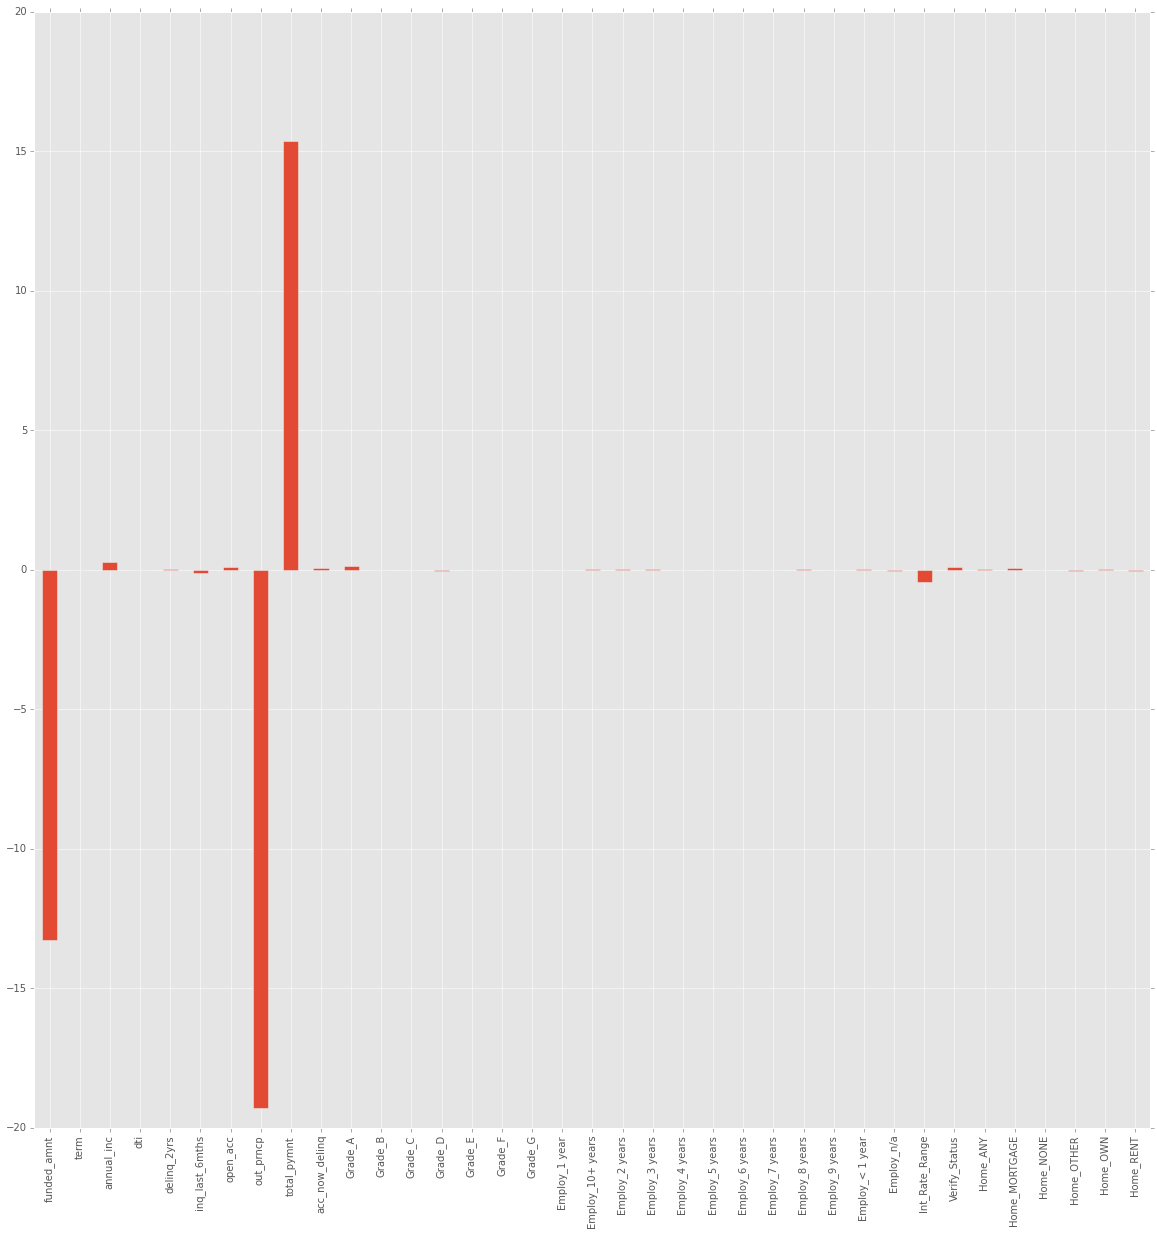

In [11]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))

weights = pd.Series(updated_logreg_obj.coef_[0],index=loan_df_finished.columns)
weights.plot(kind='bar')
plt.show()

In [12]:
warnings.simplefilter("ignore")

# SVM using 'log' for loss instead of 'hinge'
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in updated_cv_obj:
    svm_sgd.fit(scl.fit_transform(updated_X[train_idx]),updated_y[train_idx])
    yhat = svm_sgd.predict(scl.transform(updated_X[test_idx]))
    
    conf = mt.confusion_matrix(updated_y[test_idx],yhat)
    acc = mt.accuracy_score(updated_y[test_idx],yhat)

print 'SVM:', acc

SVM: 0.845583078002
